In [1]:
#
from glob import glob as gg
#
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc as rc
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
#
from netCDF4 import Dataset  
#
from datetime import datetime
from datetime import date
#
import pandas as pd
#
from scipy.interpolate import interp1d

In [2]:


#
# parameters for the creation of the forcing file that includes: - PAR
#                                                                - Kz
#                                                                - atm forcing: pressure and wind
#                                                                - ocean salinity and temperature 
# rk: - according to the simulation mesh (including spinup)
#     - perform interpolation of daily fields to fit with simulation time discretization
#

# data path
path_data = '../../data/'

# mesh infos: path and file name
path_mesh = path_data + 'MESH/'
filename_mesh = path_mesh + 'REcoM1D_mesh.nc'

# PAR infos: path and file name
path_PAR = path_data + 'ITP_PAR/'
filename_PAR = path_PAR + 'PAR_forcing.nc'

# atm forcing infos: path and file name
path_atm =  path_data + 'METEO/'
filename_atm = path_atm + 'ERA5_forcing_Polarstern.nc'

# Kz data set info: path and file name
path_MSS = path_data + 'MSS/'
filename_MSS = path_MSS +  'MOSAiC_MSS_daily_Kz.nc'

# CTD data infos: path and name
path_CTD = path_data + 'ITP_CTD_Ben/'
filename_CTD = path_CTD + 'ITP_daily_data.nc'

# output infos: path and file name
path_output = path_data + 'REcoM_forcing_data/'
filename_output = path_output + 'REcoM1D_forcing.nc'

In [3]:
# 1. load simulation mesh
#
# load discretized mesh data
#
class Mesh:
    def __init__(self, filename):
        self.read_mesh(filename)

    def read_mesh(self, filename):
        ncid = Dataset(filename, "r", format="NETCDF4")
        
        # read dates
        self.dates = ncid.variables['dates'][:]
        
        # read coordinates
        self.longitude, self.latitude = ncid.variables['longitude'][:], ncid.variables['latitude'][:]
        
        # first date of simulation after spinup
        ind1, ind2 = np.where(self.longitude==self.longitude[0])[0], np.where(self.latitude==self.latitude[0])[0]
        index = list(set(ind1) & set(ind2))[-1]
        self.start_date = np.floor(self.dates[index])
        self.end_date = np.floor(self.dates[-1])
        
        # read depth and levels
        self.zbar, self.Z, self.nlevels = ncid.variables['zbar'][:], ncid.variables['Z'][:], ncid.variables['nlevels'][:]
        
        ncid.close()
#
mesh = Mesh(filename_mesh)

In [4]:
# 2. load and process PAR data
#
# load PAR data
#
class PAR:
    def __init__(self,filename, mesh):
        self.read_PAR(filename,mesh)
    def read_PAR(self,filename,mesh):
        ncid = Dataset(filename, "r", format="NETCDF4")
        
        # read dates
        time = ncid.variables['time'][:]
        dates = []
        for tt in time:
            tmp=datetime.strptime(tt,'%Y-%m-%d %H:%M:%S')
            day, hour, minute = tmp.toordinal(), tmp.hour/24., tmp.minute/(24.*60.)
            dates.append(day+hour+minute)
        
        # constrains dates to mesh (simulation) dates
        ind1, ind2 = np.where(dates>=mesh.start_date)[0], np.where(dates<=mesh.end_date)[0]
        index = list(set(ind1) & set(ind2))
        dates=np.asarray(dates)[index]
        
        # read PAR 
        PAR = ncid.variables['PAR'][:]
        PAR = PAR[index]
        
        self.dates, self.PAR = dates, PAR
#
# tranform data to simulation format (including spinup)
#
class Process_PAR_spinup:
    def __init__(self, data, mesh):
        self.transform_PAR(data,mesh)
    def transform_PAR(self, data, mesh):
        # simulation dates & initialization
        self.dates = mesh.dates
        PAR = np.zeros(len(self.dates))
        thr = 1e-2
        
        # deal with spinup
        ind = np.where(self.dates<np.min(data.dates))[0]
        PAR[ind] = data.PAR[0]
    
        # proper simulation part
        PAR[ind[-1]+1:] = data.PAR
        
        self.PAR = PAR
        
#
# run PAR script
#
# load data (data are already sampled every 30min)
PAR_data = PAR(filename_PAR, mesh)

# add spinup to data
PAR_data_processed = Process_PAR_spinup(PAR_data,mesh)

In [5]:
# 3. load and process atm forcing (surface pressure and wind)
#
# load era5 pressure and wind speed
#
class atm_forcing:
    def __init__(self,filename, mesh):
        self.read_atm_forcing(filename,mesh)
    def read_atm_forcing(self,filename, mesh):
        # read data
        ncid = Dataset(filename, "r", format="NETCDF4")
        dates, pressure = ncid.variables['dates'][:], ncid.variables['sp'][:]
        uatm, vatm = ncid.variables['u10'][:], ncid.variables['v10'][:]
        # crop dates to simulation date
        ind1, ind2 = np.where(dates>=mesh.start_date)[0], np.where(dates<=mesh.end_date)[0]
        indices = list(set(ind1) & set(ind2))
        self.dates, self.pressure = dates[indices], pressure[indices]
        self.uatm, self.vatm = uatm[indices], vatm[indices]
        
class Process_atm_forcing:
    def __init__(self, data, mesh):
        self.process_forcing(data, mesh)
        
    def process_forcing(self, data, mesh):
        #  
        # sub/over sample data to comply with simulation time
        # 
        ind1, ind2 = np.where(mesh.dates>=mesh.start_date)[0], np.where(mesh.dates<=mesh.end_date)[0]
        indices = list(set(ind1) & set(ind2))
        dates = [d for d in mesh.dates[indices]]
        # interpolate pressure and wind
        date=[d for d in data.dates]
        fp = interp1d(date, data.pressure)
        fu, fv = interp1d(date, data.uatm), interp1d(date, data.vatm)
        P, U, V = fp(dates), fu(dates), fv(dates)
        
        # create forcing variables and manage spinup
        nt = len(mesh.dates)
        pressure, uatm, vatm = np.zeros(nt), np.zeros(nt), np.zeros(nt)
        pressure[indices], uatm[indices], vatm[indices] = P, U, V
        pressure[0:indices[0]] = pressure[indices[0]]
        uatm[0:indices[0]] = uatm[indices[0]]
        vatm[0:indices[0]] = vatm[indices[0]]
        
        # store data
        self.dates, self.pressure, self.uatm, self.vatm = mesh.dates, pressure, uatm, vatm
#
# load atm forcing
#
atm_forcing_data = atm_forcing(filename_atm, mesh)

#
# process atm forcing: simulation time discretization and spinup
#
atm_forcing_data_processed = Process_atm_forcing(atm_forcing_data, mesh)

In [6]:
def Process_2D_field(data, mesh, var):
    # reference dates and levels(mid cell)
    dates, start_date = np.asarray(mesh.dates), mesh.start_date
    index = np.where(dates>=mesh.start_date)[0]
    dates_simu = dates[index]
    #
    daily_dates = data.dates
    #
    nlvl, nt, thr = var.shape[0], len(dates), 1e-3
    #
    var_new, nlevels = np.zeros((nlvl,nt))*np.nan, np.zeros(nt)
    
    # A. estimate 2D variables
    # perform interpolation per level (level with not NaN values)
    nlvl_min, nlvl_max =  np.min(data.nlevels), np.max(data.nlevels)
    for i in range(nlvl_min+1):
        # get local interpolation coefficient from daily variables  
        v = var[i,:]
        fk = interp1d(daily_dates, v)
        # interpolate on discrete simulation time
        var_new[i,index] = fk(dates_simu)
        # deal with spinup
        var_new[i,:index[0]] = var_new[i,index[0]] 
            
    # when level with Nan (bottom) then interpolate on Non_NaN parts
    bottom_levels = np.linspace(nlvl_min + 1, nlvl_max, nlvl_max-nlvl_min).astype(int)
    for bt in bottom_levels:
        # daily variables at bottom levels
        v = var[bt,:]
        # fill with daily value for an entire day, (rk: kz=1e-7 at the bottom anyway)
        for j, dt in enumerate(daily_dates):
            ind = np.where(abs(np.floor(dates_simu)-np.floor(dt))<thr)[0]
            var_new[bt,index[0] + ind] = v[j]
        # deal with spinup    
        var_new[i,:index[0]] = var_new[i,index[0]]
        
        
    # B. estimate vertical levels of computation at each time step 
    for i,dt in enumerate(daily_dates):
        indl = np.where(abs(np.floor(dates)-dt)<thr)[0]
        nlevels[indl] = data.nlevels[i]
    # deal with spinup
    nlevels[:index[0]] = nlevels[index[0]]
    
    return dates, var_new, nlevels

In [7]:
# 4. load and process Kz data
#
# A. load Kz
#
class KZ:
    def __init__(self, filename):
        self.read_Kz(filename)
    def read_Kz(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")
        self.dates, self.z = ncid.variables['dates'][:], ncid.variables['z'][:]
        self.Kz, self.nlevels = ncid.variables['Kz'][:], ncid.variables['nlevels'][:].astype(int)
        
#
# B. tranform data to simulation format (including spinup)
#
class Process_Kz:
    def __init__(self, data, mesh):
        self.transform_Kz(data,mesh)
    def transform_Kz(self, data, mesh):
        # interpolate Kz and deals with values at bottom
        dates, Kz, nlevels = Process_2D_field(data, mesh, data.Kz)
        # store data
        self.dates, self.Kz, self.nlevels = dates, Kz, nlevels
#
# run Kz script
#

# load data
Kz_data = KZ(filename_MSS)

# process Kz data
Kz_data_processed = Process_Kz(Kz_data, mesh)

In [8]:
# 5. load and process ITP data (temperature and salinity)
#
# A. load salinity, temperature
#
class ITP:
    def __init__(self, filename):
        self.read_salinity_temperature(filename)
    def read_salinity_temperature(self, filename):

        ncid = Dataset(filename, "r", format="NETCDF4")
        
        # read dates
        self.dates, self.nlevels = ncid.variables['dates'][:], ncid.variables['nlevels'][:].astype(int)
        
        # read
        self.salinity , self.temperature = ncid.variables['salinity'][:], ncid.variables['temperature'][:]
        
#
# B. tranform data to simulation format (including spinup)
#
class Process_ITP:
    def __init__(self, data, mesh):
        self.transform_ITP_data(data, mesh)
    def transform_ITP_data(self, data, mesh):
        # B1. interpolate temperature and deals with values at bottom
        dates, temperature, nlevels = Process_2D_field(data, mesh, data.temperature)
        # B2. interpolate salinity and deals with values at bottom
        _, salinity, _ = Process_2D_field(data, mesh, data.salinity)
        self.dates, self.salinity, self.temperature, self.nlevels = dates, salinity, temperature, nlevels  
            
#        
# run ocean script
#

# load data
ITP_data = ITP(filename_CTD)

# process Kz data
ITP_data_processed = Process_ITP(ITP_data, mesh)

In [9]:
# 6. ice cover
#
# deal with ice cover 
#   -> assume full ice cover
#
class ice_cover:
    def __init__(self,mesh):
        self.create_ice_cover(mesh)
    def create_ice_cover(self, mesh):
        self.dates = mesh.dates
        self.aice = np.zeros(len(self.dates)) + 1.
aice_data = ice_cover(mesh)

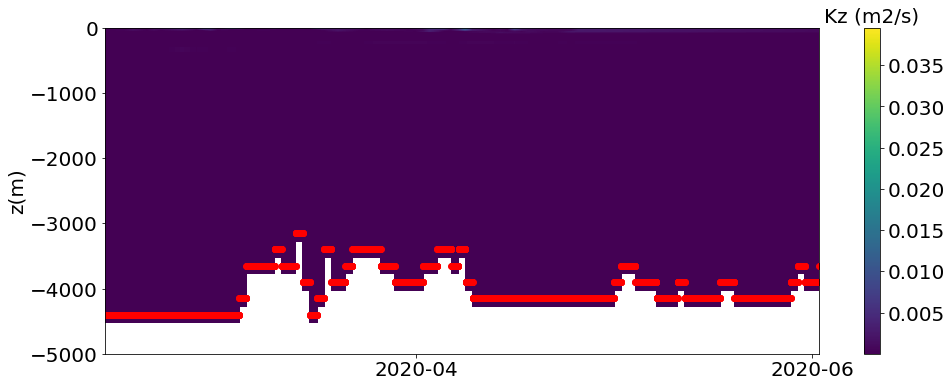

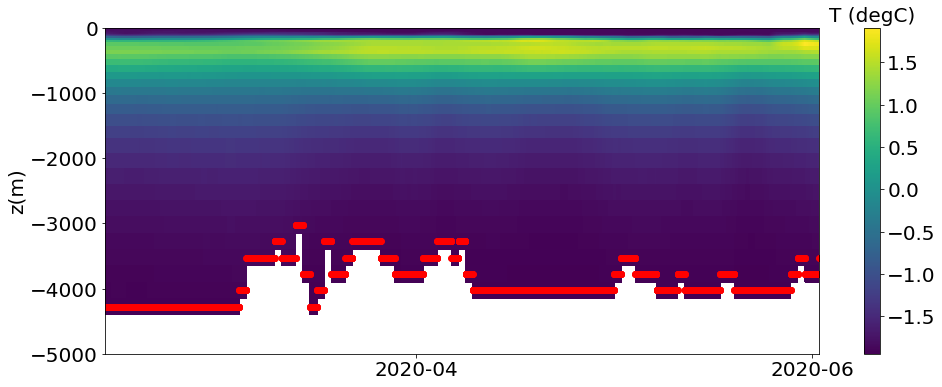

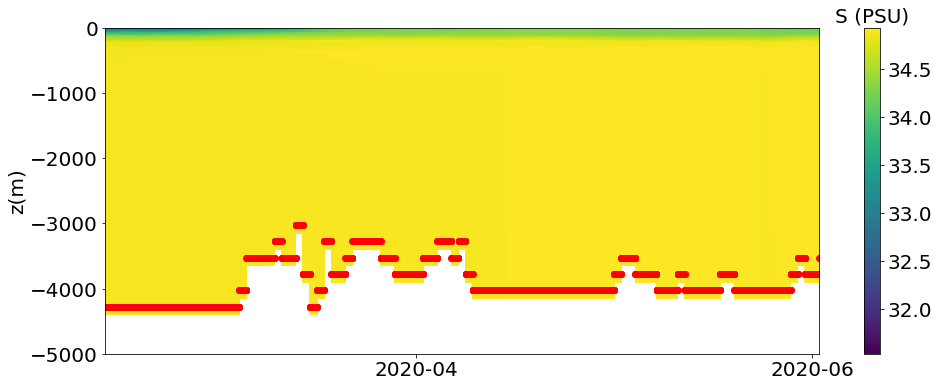

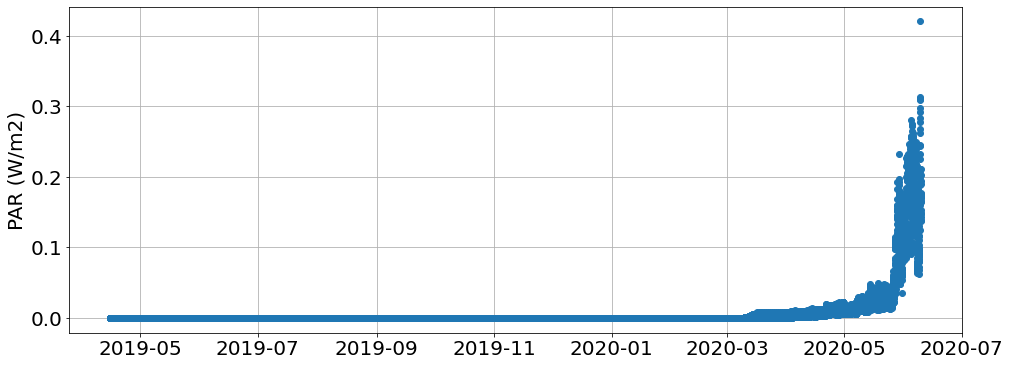

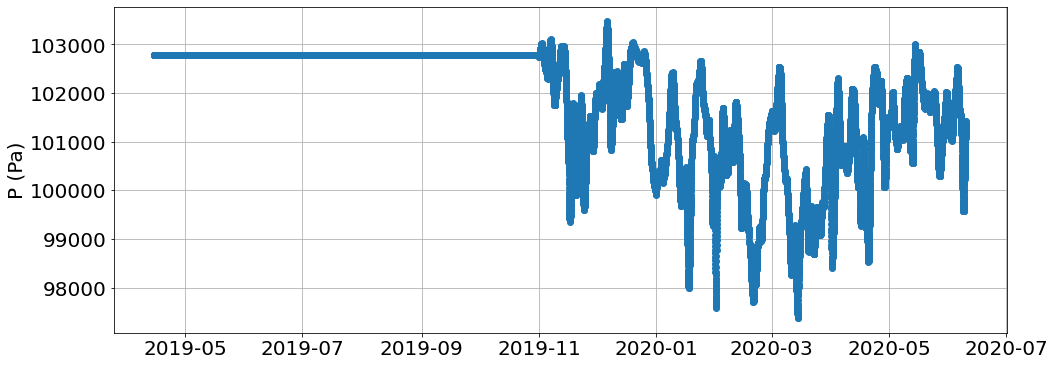

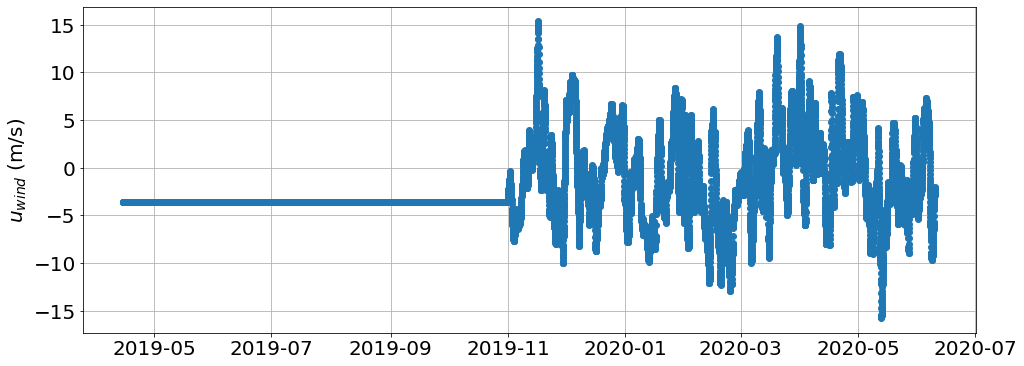

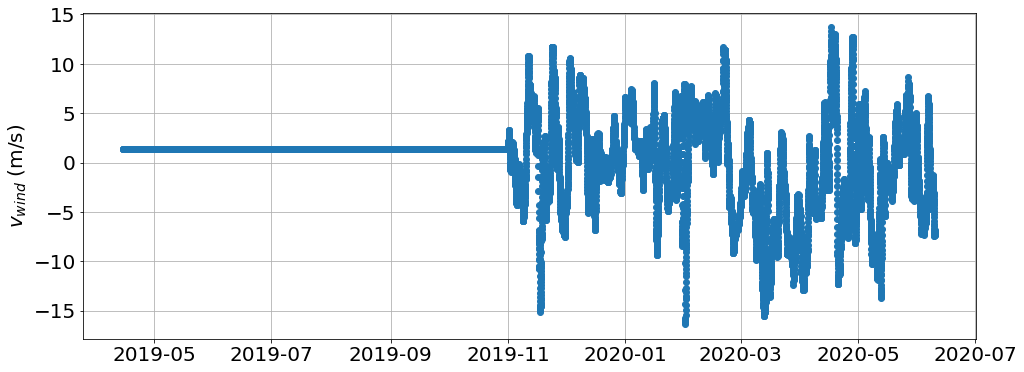

In [10]:
# 7. plot forcing data
# plot properties
fsz, dl = (16, 6), [-5000, 0]
lbsz, tcsz, mksz = 30, 20, 20
rc('xtick', labelsize=tcsz) , rc('ytick', labelsize=tcsz)
date_ref = datetime.strptime('1970-01','%Y-%m').toordinal()
date_start, date_end = datetime.strptime('2020-03-01', '%Y-%m-%d').toordinal() - date_ref,  np.max(mesh.dates) - date_ref
tl=[date_start, date_end]

def plot_2D_field(mesh, var, varname):
    
    dates, nlvl = mesh.dates, mesh.nlevels.astype(int)
    if 'Kz' in varname:
        z = mesh.zbar
    else:
        nlvl = nlvl -1
        z = mesh.Z
        
    # define figure
    fig, ax = plt.subplots(1, figsize=fsz)
    
    # plot 2D field
    varc = ax.pcolor(dates-date_ref, z, var)
    
    for i, nl in enumerate(nlvl):
        ax.plot_date(mesh.dates[i]-date_ref, z[nl], 'or')
    
    #manage the axis
    ax.set_xlim(tl),ax.set_ylim(dl), ax.set_ylabel('z(m)', fontsize=20)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=8))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
    
    # manage colorbar
    cbar = fig.colorbar(varc, ax=ax)
    cbar.ax.set_title(varname, fontsize=20)
    return

def plot_1D_field(dates, var, varname):
    # define figure
    fig, ax = plt.subplots(1, figsize=fsz)
    
    # plot 1D field
    ax.plot_date(dates-date_ref, var)
    ax.set_ylabel(varname, fontsize=20), ax.grid()
    
    return
#
# plot forcing
#
# A. Kz
data=Kz_data_processed
plot_2D_field(mesh, data.Kz, 'Kz (m2/s)')

## B. temperature and salinity
data = ITP_data_processed
plot_2D_field(mesh, data.temperature, 'T (degC)')
plot_2D_field(mesh, data.salinity, 'S (PSU)')

## C. PAR
data=PAR_data_processed
plot_1D_field(mesh.dates, data.PAR, 'PAR (W/m2)')

## D. atm forcing
data=atm_forcing_data_processed
plot_1D_field(mesh.dates, data.pressure, 'P (Pa)')
plot_1D_field(mesh.dates, data.uatm, r'$u_{wind}$' + ' (m/s)')
plot_1D_field(mesh.dates, data.vatm, r'$v_{wind}$' + ' (m/s)')

In [11]:
# 8. store forcing output for simulation
#
# save forcing to netcdf
#
class Output:
    def __init__(self, filename, mesh, PAR, ITP, Kz, aice, atm_forcing):
        self.write_recom_constant_forcing(filename, mesh, PAR, ITP, Kz, aice, atm_forcing)
        
    def write_recom_constant_forcing(self, filename, mesh, PAR, ITP, Kz, aice, atm_forcing):
        
        nt, nl = len(mesh.dates), len(mesh.zbar)
        
        # create date vector
        dates = []
        for dt in mesh.dates:
            tmp = datetime.strftime(datetime.fromordinal((int(dt))), '%Y-%m-%d')
            rest= dt - int(dt)
            tmph = np.round(rest*24*10)/10
            hour = np.floor(tmph).astype(int)
            hours = str(hour) if (hour>9) else '0'+str(hour)
            minute = int((tmph-hour)*60)
            minutes = str(minute) if (minute>9) else '0'+str(minute)
            dates.append(tmp + ' ' + hours + ':' + minutes + ':00')
        dates=np.asarray(dates)
        # store grid (Lagrangian and vertical) information
        ncid = Dataset(filename, "w", format="NETCDF4") 

        ## define dimensionss
        ncid.createDimension('time', nt)       
        ncid.createDimension('level_node', nl)
        ncid.createDimension('level_cell', nl-1)
        dimn = ('level_node', 'time')
        dimc = ('level_cell', 'time')

        ## create variables
        # dates
        dt = ncid.createVariable('dates', "S19",'time')
        dt_ordinal = ncid.createVariable('dates_ordinal', "f8",'time')
        # ice cover
        ice = ncid.createVariable('aice', "f8",'time')
                             
        # temperature and salinity
        t, s  = ncid.createVariable('temperature', "f8", dimc), ncid.createVariable('salinity', "f8",dimc)
        
        # atm forcing
        U, V = ncid.createVariable('uwind', "f8", 'time'), ncid.createVariable('vwind', "f8",'time')
        P = ncid.createVariable('sea_level_pressure', "f8", 'time')
        
        # vertical mesh
        par, kz  = ncid.createVariable('PAR_surface', "f8",'time'), ncid.createVariable('Kz', "f8",dimn)
                
        ## variables attributes
        # description
        dt_ordinal.description='dates related to python ordinal dates (reference date 01/01/0001)'
        dt.description='calendar dates'
        ice.description = 'surface of ocean covered by ice'
        t.description, s.description = 'temperature distribution in the water column',  'salinity distribution the water column'
        par.description, kz.description = 'Photosynthetically Active Radiation in the water column', 'vertical diffusivity in the water column'
        U.description, V.description = 'x-component of wind', 'y-component of wind'
        P.description = 'mean sea level pressure'
        
        # units
        dt.units='days'
        ice.units, t.units, s.units = '', 'degree (Celsius)', 'ppt'
        par.units, kz.units = 'W/m2', 'm2/s'
        U.units, V.units, P.units = 'm/s', 'm/s', 'Pa'
        
        ## fill variables
        # dates
        ncid['dates'][:] = dates
        ncid['dates_ordinal'][:] = mesh.dates
        
        # ice
        var=aice
        ncid['aice'][:] = var.aice
        
        # temperature and salinity
        var=ITP
        ncid['temperature'][:] , ncid['salinity'][:] = var.temperature, var.salinity
        
        # atm forcing
        var=atm_forcing
        ncid['uwind'][:], ncid['vwind'][:], ncid['sea_level_pressure'][:] = var.uatm, var.vatm, var.pressure

        
        # radiation and turbulence
        var=PAR
        ncid['PAR_surface'][:]=var.PAR
        var=Kz
        ncid['Kz'][:] = var.Kz
                             
        #
        ncid.close()
#
#
#
Output(filename_output, mesh, PAR_data_processed, ITP_data_processed, Kz_data_processed, aice_data, atm_forcing_data_processed)